# Projeto - Cálculo do diâmetro de um asteroide

#### Amanda Lucio, Nayara Gomes

O objetivo dos modelos é medir o diâmetro de um asteroide a partir de medidas sobre o mesmo. O *Dataset* utilizado será  **"Open Asteroid Dataset"** retirado do site https://www.kaggle.com.

Após baixar no Kaggle o arquivo *Asteroid_Updated.csv* contendo os dados sobre asteroides, vamos preparar nosso ambiente com as bibliotecas necessárias e depois importaremos os dados!

## Importando as bibliotecas

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier, plot_tree

%matplotlib inline

In [31]:
dataAsteroid = pd.read_csv('Data/Asteroid.csv')
dataAsteroid.head()

c:\users\amand\appdata\local\programs\python\python38-32\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (0,10,15,16,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,name,a,e,i,om,w,q,ad,per_y,data_arc,...,UB,IR,spec_B,spec_T,G,moid,class,n,per,ma
0,Ceres,2.769165,0.076009,10.594067,80.305532,73.597694,2.558684,2.979647,4.608202,8822.0,...,0.426,NaN,C,G,0.12,1.59478,MBA,0.213885,1683.145708,77.372096
1,Pallas,2.772466,0.230337,34.836234,173.080063,310.048857,2.133865,3.411067,4.616444,72318.0,...,0.284,NaN,B,B,0.11,1.23324,MBA,0.213503,1686.155999,59.699133
2,Juno,2.669150,0.256942,12.988919,169.852760,248.138626,1.983332,3.354967,4.360814,72684.0,...,0.433,NaN,Sk,S,0.32,1.03454,MBA,0.226019,1592.787285,34.925016
3,Vesta,2.361418,0.088721,7.141771,103.810804,150.728541,2.151909,2.570926,3.628837,24288.0,...,0.492,NaN,V,V,0.32,1.13948,MBA,0.271609,1325.432765,95.861936
4,Astraea,2.574249,0.191095,5.366988,141.576605,358.687607,2.082324,3.066174,4.130323,63507.0,...,0.411,NaN,S,S,NaN,1.09589,MBA,0.238632,1508.600458,282.366289


### Variáveis do *Dataset*

In [32]:
dataAsteroid.columns



Index(['name', 'a', 'e', 'i', 'om', 'w', 'q', 'ad', 'per_y', 'data_arc',
       'condition_code', 'n_obs_used', 'H', 'neo', 'pha', 'diameter', 'extent',
       'albedo', 'rot_per', 'GM', 'BV', 'UB', 'IR', 'spec_B', 'spec_T', 'G',
       'moid', 'class', 'n', 'per', 'ma'],
      dtype='object')

In [33]:
columns = ['a', 'e', 'i', 'om', 'w', 'q', 'ad', 'per_y', 'data_arc', 'n_obs_used', 'H', 'diameter','albedo', 'rot_per','moid', 'n', 'per', 'ma']

dataAsteroid=dataAsteroid[columns]
dataAsteroid = dataAsteroid.dropna(subset=["diameter", "rot_per"])  #removendo linhas com diâmetro null
dataAsteroid = dataAsteroid[pd.to_numeric(dataAsteroid['diameter'], errors='coerce').notnull()] #removendo linhas com valores não numéricos no diâmetro
dataAsteroid = dataAsteroid.interpolate()

dataAsteroid = dataAsteroid.astype(float)
dataAsteroid = dataAsteroid.reset_index()


In [34]:
percent_missing = dataAsteroid.isnull().sum() * 100 / len(dataAsteroid)
missing_value_df = pd.DataFrame({'column_name': dataAsteroid.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', ascending=False)

,column_name,percent_missing
index,index,0.0
n_obs_used,n_obs_used,0.0
per,per,0.0
n,n,0.0
moid,moid,0.0
rot_per,rot_per,0.0
albedo,albedo,0.0
diameter,diameter,0.0
H,H,0.0
data_arc,data_arc,0.0


## Diminuindo Dataset

In [35]:
len(dataAsteroid) #número de rows

11187

In [36]:
np.random.seed(10)

remove_n = 5000
dataAsteroid_indices = np.random.choice(dataAsteroid.index, remove_n, replace=False)
dataAsteroid = dataAsteroid.drop(dataAsteroid_indices)

In [37]:
len(dataAsteroid.index) #número de rows

6187

### Verificação da distribuição dos dados da variável resposta 

c:\users\amand\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


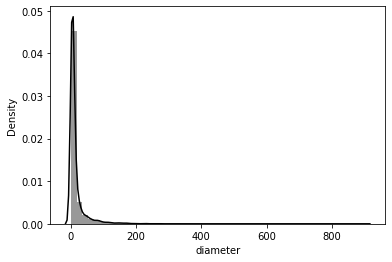

In [38]:
sns.distplot(dataAsteroid['diameter'], color='black')
plt.show()

#### Histograma dos Valores por Atributo

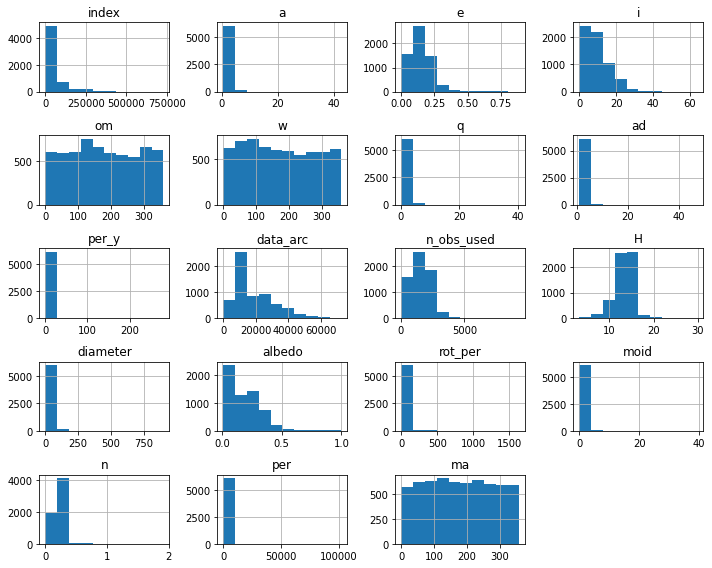

In [39]:
dataAsteroid.hist(figsize=(10,8))
plt.tight_layout()
plt.show()

### Detectar e Remover outliers

In [40]:
dataAsteroid.describe()

,index,a,e,i,om,w,q,ad,per_y,data_arc,n_obs_used,H,diameter,albedo,rot_per,moid,n,per,ma
count,6187.000000,6187.000000,6187.000000,6187.000000,6187.000000,6187.000000,6187.000000,6187.000000,6187.000000,6187.000000,6187.000000,6187.000000,6187.000000,6187.000000,6187.000000,6187.000000,6187.000000,6187.000000,6187.000000
mean,46417.691773,2.771367,0.150529,9.641778,179.065375,174.484696,2.362466,3.180267,4.783436,18045.848230,1561.024244,13.363132,15.346596,0.192023,24.308847,1.382984,0.236190,1747.150112,179.211183
std,74392.528002,1.043393,0.089519,6.896414,103.442906,104.530660,0.875875,1.315004,5.271623,11740.013609,766.355082,2.037210,29.859407,0.142964,80.031384,0.865042,0.100211,1925.460480,102.599775
min,1.000000,0.642196,0.001141,0.052952,0.000738,0.029757,0.139981,1.014592,0.514647,3.000000,58.000000,3.200000,0.002500,0.011600,0.043333,0.000316,0.003522,187.974705,0.057141
25%,3735.000000,2.383609,0.090047,4.417074,93.096088,84.189173,1.983817,2.785675,3.680110,8698.500000,969.000000,12.300000,3.975500,0.070000,4.605500,0.993422,0.187450,1344.160138,92.374138
50%,16209.000000,2.662095,0.138765,8.458982,173.233984,168.779481,2.263004,3.060116,4.343537,13887.000000,1546.000000,13.600000,6.557000,0.172000,7.510000,1.277340,0.226918,1586.477013,177.973012
75%,54653.000000,3.023746,0.193358,13.075859,271.117733,266.969942,2.652302,3.390486,5.258068,24633.000000,2111.500000,14.700000,12.671500,0.274000,14.877500,1.658425,0.267825,1920.509272,265.902440
max,729174.000000,42.781267,0.889898,64.006900,359.899762,359.988886,40.465671,47.240969,279.826385,72684.000000,9325.000000,29.900000,900.000000,1.000000,1641.000000,39.507000,1.915151,102206.587270,359.903144


In [41]:
# Removendo outliers a partir dos valores acima
numOfOutliers= len(dataAsteroid)- len(dataAsteroid[(np.abs(stats.zscore(dataAsteroid)) < 3).all(axis=1)])
dataAsteroid=pd.DataFrame(dataAsteroid[(np.abs(stats.zscore(dataAsteroid)) < 3).all(axis=1)])

# dataAsteroid = dataAsteroid[dataAsteroid.a < 20]
# dataAsteroid = dataAsteroid[dataAsteroid.q < 6]
# dataAsteroid = dataAsteroid[dataAsteroid.n_obs_used < 6000]
# dataAsteroid = dataAsteroid[dataAsteroid.per_y < 15]
# dataAsteroid = dataAsteroid[dataAsteroid.diameter < 400]
# dataAsteroid = dataAsteroid.reset_index()

### Analisando correlações

In [42]:
corr_matrix = dataAsteroid.corr()
corr_matrix["diameter"].sort_values(ascending=False).head()

diameter      1.000000
data_arc      0.642981
n_obs_used    0.520335
a             0.421545
per_y         0.416301
Name: diameter, dtype: float64

<AxesSubplot:>

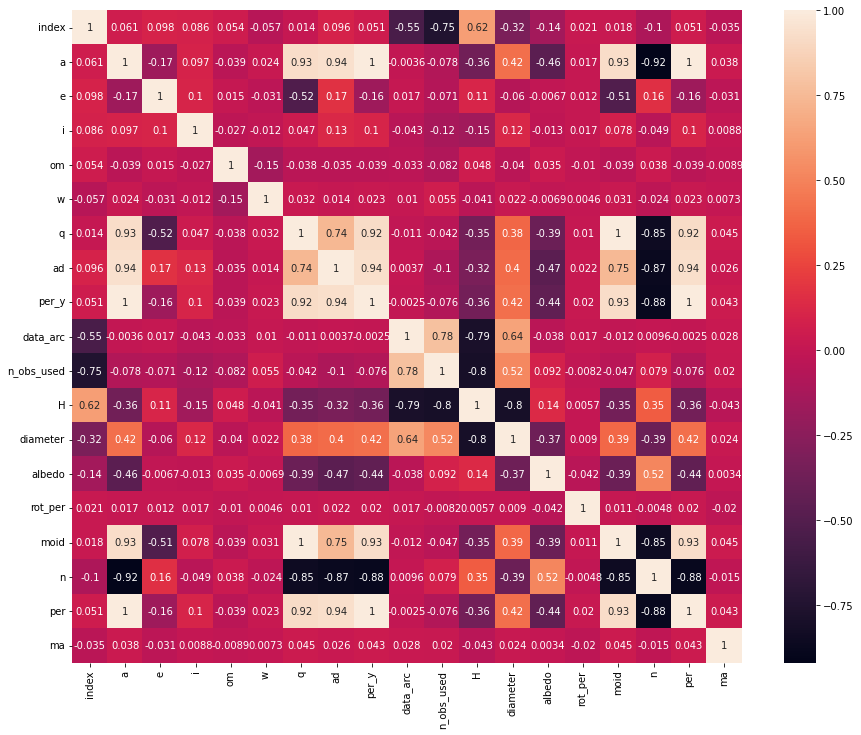

In [43]:
plt.subplots(figsize=(15,12))
sns.heatmap(corr_matrix,annot=True,annot_kws={'size':10})

### Separando Dados

In [44]:
X = dataAsteroid.drop(['diameter'],axis = 1)
y = dataAsteroid['diameter']
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1242)


In [45]:
X

,index,a,e,i,om,w,q,ad,per_y,data_arc,n_obs_used,H,albedo,rot_per,moid,n,per,ma
75,76,2.668111,0.132298,2.422958,1.149350,61.830284,2.315125,3.021097,4.358269,51236.0,2817.0,8.52,0.177,9.0120,1.329080,0.226151,1591.857740,283.372844
134,135,2.286339,0.085215,9.579216,186.454929,132.884873,2.091510,2.481169,3.457158,51977.0,2580.0,9.69,0.201,11.4969,1.091580,0.285097,1262.727053,216.903941
141,142,2.760357,0.074406,11.444569,332.983835,252.396104,2.554970,2.965745,4.586233,50966.0,2594.0,9.12,0.044,22.0050,1.575910,0.214910,1675.121685,81.082066
147,148,2.175205,0.064776,0.939377,159.609167,250.943865,2.034303,2.316107,3.208178,46784.0,2903.0,10.79,0.152,26.0230,1.044130,0.307223,1171.787013,227.627330
153,154,2.755993,0.277138,11.387527,40.994893,45.859915,1.992201,3.519784,4.575360,52511.0,2202.0,11.39,0.027,7.9597,1.025790,0.215420,1671.150404,89.093191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10922,255092,3.007410,0.118016,9.269796,216.051029,146.148770,2.652489,3.362332,5.215515,6817.0,346.0,15.70,0.146,3.1580,1.655920,0.188980,1904.966934,243.379447
10925,255667,2.387981,0.176874,1.697229,209.785774,160.810624,1.965610,2.810352,3.690239,7046.0,253.0,17.20,0.059,7.6340,0.964610,0.267090,1347.859860,131.744565
10928,257167,2.635484,0.219516,3.892682,30.887020,7.573783,2.056952,3.214016,4.278571,7584.0,254.0,16.60,0.158,5.5780,1.064040,0.230363,1562.747923,357.765815
10929,259804,2.338090,0.235408,22.831729,8.962988,105.876957,1.787686,2.888495,3.575198,6677.0,327.0,16.30,0.052,5.7910,0.922978,0.275684,1305.841231,111.214419


### Geramos os folds para validação cruzada

In [46]:
kf = KFold(n_splits=10, shuffle=True, random_state=111)

In [47]:
def avalia_classificador(model, kf, X, y, function_RMSE):
    metric_valid = []
    metric_train = []
    y_preds = np.zeros(X.shape[0])
    # a cada iteração em kf, temos k-1 conjuntos para treino e 1 para validação
    # train e valid recebem os indices de treino e validação em cada rodada.
    for train, valid in kf.split(X,y):
        x_train = X.iloc[train] # escolhe apenas os indices de treino
        y_train = y.iloc[train]
        x_valid = X.iloc[valid] # escolhe apenas os indices de validação
        y_valid = y.iloc[valid]
        model.fit(x_train, y_train) # treina o classificador com dados de treino
        y_pred_train = model.predict(x_train) # faz predições nos dados de treino
        y_pred_valid = model.predict(x_valid) # faz predições nos dados de validação
        y_preds[valid] = y_pred_valid # guarda as previsões do fold corrente
        
        # salvando métricas obtidas no dado de treino (k-1 folds) e validação (1 fold)
        metric_valid.append(function_RMSE(y_valid, y_pred_valid)) 
        metric_train.append(function_RMSE(y_train, y_pred_train)) 
    
    # retorna as previsões e a média das métricas de treino e validação
    # obtidas nas iterações do Kfold
    return y_preds, np.array(metric_valid).mean(), np.array(metric_train).mean()

In [48]:
from sklearn.metrics import mean_squared_error
def function_RMSE(y_real, y_pred): 
    return mean_squared_error(y_real, y_pred)**0.5

Modelos: 

* Modelos Lineares
    * Regressão Linear
* Modelos não-lineares    
    * Árvores de decisão
    * Random Forest
    * Gradient Boosting
    * SVM
    * Redes Neurais

#### Baseline

In [49]:
media_valor_m2 = np.mean(y)

In [50]:
#Gera um vetor artificial com o valor da média repetido pelo número de linhas do nosso conjunto.
y_media = np.array([media_valor_m2]*y.shape[0])

#Calcula o desempenho como se a predição do modelo fosse o y médio
print(function_RMSE(y, y_media))

15.425385526455457


#### Regressão Linear

Temos o seguinte modelo para estimar o diâmetro do asteroide:

**diameter = β0 + β1 × 'data_arc' + β2 ×'n_obs_used' + β3 × 'a'....**

In [51]:
from sklearn.linear_model import LinearRegression

modelLinearRegression = LinearRegression(fit_intercept=True, normalize=True) 

In [52]:
preds, rmse_val, rmse_train = avalia_classificador(modelLinearRegression, kf, X, y, function_RMSE) # treina, valida e calcula desempenho
print('RMSE (validação): ', rmse_val)
print('RMSE (treino): ', rmse_train)

RMSE (validação):  7.52145840648642
RMSE (treino):  7.509316768801699


In [53]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Cria uma nova matriz de atributos com as features polinomiais de grau 2
X_new = PolynomialFeatures(2).fit_transform(X) 

# Reescalona os dados entre 0 e 1 (valor padrão do MinMaxScaler)
X_new = MinMaxScaler().fit_transform(X_new)
X_new = pd.DataFrame(X_new)
print('Número de atributos após transformação:', X_new.shape[1])
preds, rmse_val, rmse_train = avalia_classificador(modelLinearRegression, kf, X_new, y, function_RMSE) 
print('RMSE (validação): ', rmse_val)
print('RMSE (treino): ', rmse_train)

Número de atributos após transformação: 190
RMSE (validação):  4.362486808130292
RMSE (treino):  3.388565599077425


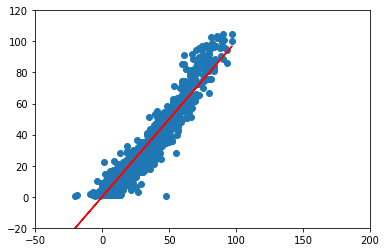

In [54]:
plt.scatter(preds, y);
plt.plot(preds,preds, c ='r')
ax = plt.gca()
ax.set_xlim([-50, 200])
ax.set_ylim([-20, 120])

plt.show()

#### Árvore de decisão

In [55]:
from sklearn import tree
modelTreeDecision = tree.DecisionTreeRegressor(max_features=5, max_depth=3, random_state=10)

In [56]:
preds, rmse_val, rmse_train = avalia_classificador(modelTreeDecision, kf, X, y, function_RMSE) 
print('RMSE (validação): ', rmse_val)
print('RMSE (treino): ', rmse_train)

RMSE (validação):  9.672168807667479
RMSE (treino):  9.315812560869997


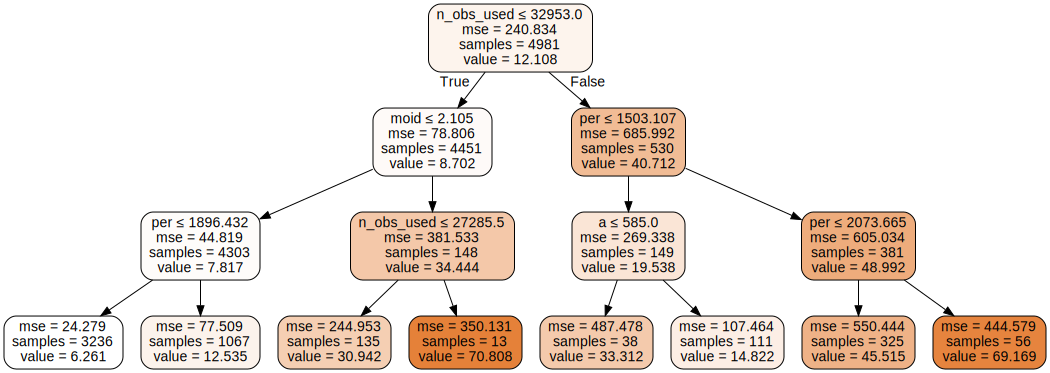

In [57]:
import graphviz 

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

columns = ['a', 'e', 'i', 'om', 'w', 'q', 'ad', 'per_y', 'data_arc', 'n_obs_used', 'H', 'diameter','albedo', 'rot_per','moid', 'n', 'per', 'ma']

dot_data = tree.export_graphviz(modelTreeDecision, out_file=None, 
                                feature_names=columns,  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

#### Random Forest 

In [58]:
from sklearn.ensemble import RandomForestRegressor

modelRandomForest = RandomForestRegressor(n_estimators=100, random_state=26)

In [59]:
preds, rmse_val, rmse_train = avalia_classificador(modelRandomForest, kf, X, y, function_RMSE) 
print('RMSE (validação): ', rmse_val)
print('RMSE (treino): ', rmse_train)

RMSE (validação):  2.030011742098371
RMSE (treino):  0.7815634541632256


#### Gradient Boosting

In [66]:
from sklearn.ensemble import GradientBoostingRegressor
modelGradientBoosting = GradientBoostingRegressor(learning_rate=0.015, max_depth=3, max_features = 18, min_samples_leaf=1,n_estimators=1500, random_state=2,subsample = 0.2)

In [67]:
preds, rmse_val, rmse_train = avalia_classificador(modelGradientBoosting, kf, X, y, function_RMSE) 
print('RMSE (validação): ', rmse_val)
print('RMSE (treino): ', rmse_train)

RMSE (validação):  1.9836265342570005
RMSE (treino):  1.3559726455584127


#### SVM

In [61]:
from sklearn import svm
modelSVM = svm.SVR(gamma='auto')

In [63]:
preds, rmse_val, rmse_train = avalia_classificador(modelSVM, kf, X, y, function_RMSE) 
print('RMSE (validação): ', rmse_val)
print('RMSE (treino): ', rmse_train)

RMSE (validação):  16.330125422036563
RMSE (treino):  15.88325922378021


#### Redes Neurais